In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib_venn import venn2_unweighted
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV 

In [ ]:
### specifying a path for Data folder in Github
PATH = "./Data"

In [ ]:
### pickling the data to retrieve the driver mutations

### COMMENTED OUT AS THE FILES ARE ALREADY PRESENT IN GITHUB

#with open(PATH+'OncogenicMutations_Dictionary.p', 'rb') as f:

#    driver_gene = pickle.load(f)
#    print(driver_gene)

In [ ]:
### COMMENTED OUT AS THE FILES ARE ALREADY PRESENT IN GITHUB

#len(driver_gene)
#file = open(PATH+"latent_driver_mut.txt","w")
#for loc in driver_gene:
#  file.write(loc+"\n")
#file.close()

In [ ]:
### COMMENTED OUT AS THE FILES ARE ALREADY PRESENT IN GITHUB

#split = [i.split("_", 1)[0] for i in driver_gene]
#drivers = set(split)
#len(drivers)


#file = open(PATH+"latent_drivers.txt","w")
#for gene in drivers:
#  file.write(gene+"\n")
#file.close()

In [2]:
### introduction of the cancer driver mutations from Bengi's article

driver_gene = pd.read_csv(PATH+"latent_drivers.txt", delimiter="\t", header=None, names=["gene"])
drivers = driver_gene["gene"].values.tolist()
print(drivers)

['BRCA2', 'MEN1', 'CDK4', 'NTRK3', 'BRIP1', 'FBXW7', 'ETV6', 'NPM1', 'PTPRD', 'PPARG', 'BARD1', 'POLE', 'CYSLTR2', 'C15orf23', 'XPO1', 'PDGFRB', 'PDGFRA', 'SLC22A18', 'SRSF2', 'SF3B1', 'OPCML', 'HRAS', 'CRBN', 'MAP2K2', 'MAX', 'RAD54B', 'NF1', 'AKT1', 'IDH1', 'ERCC2', 'RHEB', 'U2AF1', 'ERBB4', 'CDC73', 'CDKN2B', 'GNAS', 'PIK3R2', 'RET', 'BRAF', 'MYCN', 'AKT3', 'RAD54L', 'NBN', 'RAB35', 'BAX', 'NOTCH1', 'NUP93', 'SDHAF2', 'CTLA4', 'DIS3', 'FGFR4', 'NTRK1', 'FLT3', 'CREBBP', 'RASA1', 'VHL', 'MYC', 'CTCF', 'SDHD', 'KEAP1', 'KLF6', 'MYOD1', 'CSF3R', 'KIT', 'MRE11A', 'TSC2', 'ARAF', 'EIF2C2', 'JAGN1', 'WWOX', 'PDGFRL', 'FAS', 'IGF1R', 'FAT1', 'RB1', 'IRF1', 'FLCN', 'MYD88', 'STK11', 'SDHB', 'TERT', 'BMPR1A', 'PTPN12', 'KRAS', 'WRN', 'RAC1', 'CCND3', 'PLCG2', 'RBBP8', 'ELF3', 'GNAQ', 'SDHC', 'TMEM127', 'EPAS1', 'FOXA1', 'KCNJ5', 'PTPRT', 'CHEK2', 'LZTS1', 'SHOC2', 'MAP2K4', 'TSC1', 'CDKN1B', 'ING1', 'PPP2R1A', 'WT1', 'FGFR2', 'GJB2', 'SOX9', 'KDM5C', 'ARHGAP26', 'SMAD3', 'JAK1', 'MSH6', 'PIM

In [3]:
### introduction of mutation data and filtering it to contain only the genes those have the coding and point mutations

mut_df = pd.read_csv(PATH+"data_mutations-edit.csv", delimiter=";")

#### removing the synonymous variants

mut_df = mut_df[mut_df["Consequence"].str.contains("synonymous_variant") == False]


#### removing the mutations that do not affect the protein sequence

mut_df = mut_df[mut_df["Consequence"].str.contains("splice_donor_variant") == False]
mut_df = mut_df[mut_df["Consequence"].str.contains("splice_acceptor_variant") == False]
mut_df = mut_df[mut_df["Consequence"].str.contains("3_prime_UTR_variant") == False]
mut_df = mut_df[mut_df["Consequence"].str.contains("5_prime_UTR_variant") == False]
mut_df = mut_df[mut_df["Consequence"].str.contains("intron_variant") == False]


#### filtering the Consequence column to only have missense, coding seq, frameshift and stop gained mutations

mut_df = mut_df[mut_df['Consequence'].str.contains('missense_variant|stop_gained|frameshift_variant|coding_sequence_variant') == True]
mut_df["Consequence"].value_counts()


### filtering the mutations to be the only ones present in the drivers
mut_df_driver = mut_df[mut_df['Hugo_Symbol'].isin(drivers)]

In [4]:
mut_df_driver

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Codons,Hotspot,Annotation_Status,DNA_VAF
10,NTRK1,4914.0,NaN,GRCh37,1,156849089,156849089,+,missense_variant,Missense_Mutation,...,ENST00000524377.1:c.1981G>A,p.Gly661Arg,p.G661R,ENST00000524377,NM_002529.3,661.0,Gga/Aga,0,SUCCESS,0.2075
54,TP53,7157.0,NaN,GRCh37,17,7577058,7577058,+,stop_gained,Nonsense_Mutation,...,ENST00000269305.4:c.880G>T,p.Glu294Ter,p.E294*,ENST00000269305,NM_001126112.2,294.0,Gag/Tag,0,SUCCESS,0.8846
55,CDK12,51755.0,NaN,GRCh37,17,37680973,37680973,+,stop_gained,Nonsense_Mutation,...,ENST00000447079.4:c.3142C>T,p.Arg1048Ter,p.R1048*,ENST00000447079,NM_015083.1,1048.0,Cga/Tga,0,SUCCESS,0.9512
174,MYOD1,4654.0,NaN,GRCh37,11,17742999,17742999,+,missense_variant,Missense_Mutation,...,ENST00000250003.3:c.907G>T,p.Ala303Ser,p.A303S,ENST00000250003,NM_002478.4,303.0,Gcc/Tcc,0,SUCCESS,0.2449
255,PTPRT,11122.0,NaN,GRCh37,20,40827958,40827958,+,missense_variant,Missense_Mutation,...,ENST00000373198.4:c.2470G>A,p.Asp824Asn,p.D824N,ENST00000373198,NM_133170.3,824.0,Gac/Aac,0,SUCCESS,0.5312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380412,TET2,54790.0,NaN,GRCh37,4,106156345,106156345,+,missense_variant,Missense_Mutation,...,ENST00000380013.4:c.1246C>T,p.Pro416Ser,p.P416S,ENST00000380013,NM_001127208.2,416.0,Cct/Tct,0,SUCCESS,0.2208
380413,TET2,54790.0,NaN,GRCh37,4,106157065,106157065,+,missense_variant,Missense_Mutation,...,ENST00000380013.4:c.1966C>T,p.Pro656Ser,p.P656S,ENST00000380013,NM_001127208.2,656.0,Ccc/Tcc,0,SUCCESS,0.2473
380414,TET2,54790.0,NaN,GRCh37,4,106157884,106157884,+,missense_variant,Missense_Mutation,...,ENST00000380013.4:c.2785C>T,p.Pro929Ser,p.P929S,ENST00000380013,NM_001127208.2,929.0,Cct/Tct,0,SUCCESS,0.2558
380532,TERT,7015.0,NaN,GRCh37,5,1264616,1264616,+,missense_variant,Missense_Mutation,...,ENST00000310581.5:c.2746G>A,p.Gly916Ser,p.G916S,ENST00000310581,NM_198253.2,916.0,Ggc/Agc,0,SUCCESS,0.0785


In [5]:
### patient data contains the PATIENT-IDs and age data which is what we need to classify the patients accordingly

patient = pd.read_csv(PATH+"data_clinical_patient-edit.txt", delimiter="\t")
print(patient)

     PATIENT_ID     SEX   OS_STATUS OS_MONTHS FIRST_THERAPY  \
0         DO472    Male    0:LIVING       NaN           NaN   
1         DO477    Male  1:DECEASED       NaN           NaN   
2         DO479    Male    0:LIVING       NaN           NaN   
3         DO483  Female    0:LIVING       NaN           NaN   
4         DO496  Female    0:LIVING         0           NaN   
...         ...     ...         ...       ...           ...   
2578   DO222306  Female    0:LIVING       NaN           NaN   
2579   DO222307    Male    0:LIVING       NaN           NaN   
2580   DO222308  Female    0:LIVING       NaN           NaN   
2581   DO222309  Female    0:LIVING       NaN           NaN   
2582   DO224498    Male    0:LIVING       NaN  No Treatment   

     FIRST THERAPY_RESPONSE   AGE TOBACCO_SMOKING_HISTORY_INDICATOR  \
0                       NaN  53.0                               NaN   
1                       NaN  79.0                               NaN   
2                       NaN  3

In [6]:
### sample data contains both the SAMPLE-IDs and PATIENT-IDs, we use this data as a bridge to filter the sample IDs in zscore data according to the ages of patient IDs

sample = pd.read_csv(PATH+"data_clinical_sample-edit.txt", delimiter="\t")
print(sample)

     SAMPLE_ID PATIENT_ID PROJECT_CODE STAGE GRADE ICD_10     ORGAN_SYSTEM  \
0       SP1003      DO496      BLCA-US   NaN   NaN  C67.9  URINARY BLADDER   
1      SP10084     DO4766      BRCA-US   NaN   NaN  C50.9           BREAST   
2       SP1009      DO498      BLCA-US   NaN   NaN  C67.9  URINARY BLADDER   
3      SP10150     DO4796      BRCA-US   NaN   NaN  C50.9           BREAST   
4     SP101515    DO46325        OV-AU   III    G3  C48.2            OVARY   
...        ...        ...          ...   ...   ...    ...              ...   
2917   SP99333    DO45303      LIRI-JP     3   NaN    C22            LIVER   
2918   SP99337    DO45305      LIRI-JP     4   NaN    C22            LIVER   
2919   SP99341    DO45307      LIRI-JP     4   NaN    C22            LIVER   
2920   SP99345    DO45309      LIRI-JP     3   NaN    C22            LIVER   
2921    SP9979     DO4719      BRCA-US   NaN   NaN  C50.9           BREAST   

     HISTOLOGY_ABBREVIATION                         HISTOLOGY H

In [7]:
### merging the sample and patient data according to the patient ID

sample_patient = pd.merge(sample, patient, how = "left", on = "PATIENT_ID")
print(sample_patient)

     SAMPLE_ID PATIENT_ID PROJECT_CODE STAGE GRADE ICD_10     ORGAN_SYSTEM  \
0       SP1003      DO496      BLCA-US   NaN   NaN  C67.9  URINARY BLADDER   
1      SP10084     DO4766      BRCA-US   NaN   NaN  C50.9           BREAST   
2       SP1009      DO498      BLCA-US   NaN   NaN  C67.9  URINARY BLADDER   
3      SP10150     DO4796      BRCA-US   NaN   NaN  C50.9           BREAST   
4     SP101515    DO46325        OV-AU   III    G3  C48.2            OVARY   
...        ...        ...          ...   ...   ...    ...              ...   
2917   SP99333    DO45303      LIRI-JP     3   NaN    C22            LIVER   
2918   SP99337    DO45305      LIRI-JP     4   NaN    C22            LIVER   
2919   SP99341    DO45307      LIRI-JP     4   NaN    C22            LIVER   
2920   SP99345    DO45309      LIRI-JP     3   NaN    C22            LIVER   
2921    SP9979     DO4719      BRCA-US   NaN   NaN  C50.9           BREAST   

     HISTOLOGY_ABBREVIATION                         HISTOLOGY H

In [8]:
### creating of a dictionary as sample ID and age are unique pairs

subset1 = sample_patient[["SAMPLE_ID", "AGE"]]
sub_dct1 = subset1.set_index("SAMPLE_ID")["AGE"].to_dict()
print(sub_dct1)

{'SP1003': 53.0, 'SP10084': 64.0, 'SP1009': 84.0, 'SP10150': 48.0, 'SP101515': 54.0, 'SP101519': 54.0, 'SP101521': 52.0, 'SP101523': 52.0, 'SP101524': 52.0, 'SP101526': 60.0, 'SP101528': 72.0, 'SP101532': 58.0, 'SP101536': 77.0, 'SP101540': 70.0, 'SP101544': 59.0, 'SP101548': 62.0, 'SP101552': 67.0, 'SP101554': 67.0, 'SP101558': 46.0, 'SP101560': 46.0, 'SP101564': 54.0, 'SP101572': 66.0, 'SP101576': 60.0, 'SP101580': 73.0, 'SP101584': 68.0, 'SP101588': 60.0, 'SP101592': 58.0, 'SP101596': 61.0, 'SP101600': 45.0, 'SP101604': 65.0, 'SP101606': 65.0, 'SP101610': 57.0, 'SP101612': 57.0, 'SP101616': 54.0, 'SP101618': 54.0, 'SP101622': 39.0, 'SP101624': 39.0, 'SP101628': 69.0, 'SP101630': 69.0, 'SP101634': 58.0, 'SP101636': 58.0, 'SP101638': 58.0, 'SP101642': 59.0, 'SP101648': 51.0, 'SP101650': 51.0, 'SP101654': 62.0, 'SP101658': 55.0, 'SP101662': 49.0, 'SP101666': 74.0, 'SP101670': 65.0, 'SP101674': 48.0, 'SP101678': 61.0, 'SP101686': 66.0, 'SP101690': 70.0, 'SP101694': 77.0, 'SP101700': 55.

In [9]:
### classifying the sample IDs to contain patients that are age and storing them respectively

keep_sample = []

for key in sub_dct1.keys():
  age = sub_dct1.get(key)
  if age >= 70.0:
    keep_sample.append(key)

In [10]:
### subsetting the data to contain only the patients that are either 60 or older than 60

sample_patient = sample_patient[sample_patient["SAMPLE_ID"].isin(keep_sample)]
sample_patient


,SAMPLE_ID,PATIENT_ID,PROJECT_CODE,STAGE,GRADE,ICD_10,ORGAN_SYSTEM,HISTOLOGY_ABBREVIATION,HISTOLOGY,HISTOLOGY_TIER1,...,SEX,OS_STATUS,OS_MONTHS,FIRST_THERAPY,FIRST THERAPY_RESPONSE,AGE,TOBACCO_SMOKING_HISTORY_INDICATOR,TOBACCO_SMOKING_INTENSITY,ALCOHOL,ALCOHOL_HISTORY_INTENSITY
2,SP1009,DO498,BLCA-US,NaN,NaN,C67.9,URINARY BLADDER,Bladder-TCC,"Transitional cell carcinoma, NOS",ENDODERM,...,Male,0:LIVING,0,NaN,NaN,84.0,NaN,NaN,NaN,NaN
10,SP101528,DO46331,OV-AU,III,G2,C48.2,OVARY,Ovary-AdenoCA,"Serous cystadenocarcinoma, NOS",MESODERM,...,Female,1:DECEASED,2.013.157.895,NaN,NaN,72.0,NaN,NaN,NaN,NaN
12,SP101536,DO46334,OV-AU,III,G3,C48.2,OVARY,Ovary-AdenoCA,"Serous cystadenocarcinoma, NOS",MESODERM,...,Female,1:DECEASED,1.631.578.947,NaN,NaN,77.0,NaN,NaN,NaN,NaN
13,SP101540,DO46336,OV-AU,IV,G2,C57,OVARY,Ovary-AdenoCA,"Serous cystadenocarcinoma, NOS",MESODERM,...,Female,1:DECEASED,2.184.210.526,NaN,NaN,70.0,NaN,NaN,NaN,NaN
23,SP101580,DO46354,OV-AU,III,G3,C56,OVARY,Ovary-AdenoCA,"Serous cystadenocarcinoma, NOS",MESODERM,...,Female,1:DECEASED,2.773.026.316,NaN,NaN,73.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,SP99305,DO45289,LIRI-JP,3,NaN,C22,LIVER,Biliary-AdenoCA,Cholangiocarcinoma,ENDODERM,...,Female,0:LIVING,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN
2913,SP99317,DO45295,LIRI-JP,2,NaN,C22,LIVER,Biliary-AdenoCA,Cholangiocarcinoma,ENDODERM,...,Male,0:LIVING,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN
2915,SP99325,DO45299,LIRI-JP,1,NaN,C22,LIVER,Biliary-AdenoCA,Cholangiocarcinoma,ENDODERM,...,Female,0:LIVING,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN
2920,SP99345,DO45309,LIRI-JP,3,NaN,C22,LIVER,Biliary-AdenoCA,Cholangiocarcinoma,ENDODERM,...,Male,1:DECEASED,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN


In [11]:
### creating of a dictionary as sample ID and sex are unique pairs

subset2 = sample_patient[["SAMPLE_ID", "SEX"]]
sub_dct2 = subset2.set_index("SAMPLE_ID")["SEX"].to_dict()
print(sub_dct2)

{'SP1009': 'Male', 'SP101528': 'Female', 'SP101536': 'Female', 'SP101540': 'Female', 'SP101580': 'Female', 'SP101666': 'Female', 'SP101690': 'Female', 'SP101694': 'Female', 'SP101931': 'Female', 'SP102074': 'Female', 'SP102096': 'Female', 'SP102123': 'Female', 'SP102168': 'Female', 'SP102174': 'Female', 'SP102177': 'Female', 'SP102499': 'Male', 'SP102507': 'Male', 'SP102511': 'Male', 'SP102547': 'Male', 'SP102591': 'Male', 'SP102597': 'Male', 'SP102611': 'Male', 'SP102622': 'Male', 'SP102626': 'Male', 'SP102690': 'Male', 'SP102733': 'Female', 'SP102735': 'Female', 'SP102755': 'Male', 'SP102827': 'Male', 'SP102830': 'Male', 'SP102913': 'Female', 'SP102989': 'Male', 'SP102993': 'Male', 'SP103065': 'Male', 'SP103069': 'Male', 'SP103140': 'Female', 'SP103144': 'Female', 'SP103197': 'Male', 'SP103201': 'Male', 'SP103261': 'Female', 'SP103265': 'Female', 'SP103507': 'Male', 'SP103694': 'Female', 'SP103697': 'Female', 'SP103742': 'Male', 'SP103745': 'Male', 'SP103856': 'Female', 'SP104056': '

In [12]:
female_pat = []
male_pat = []

for key in sub_dct2.keys():
    sex = sub_dct2.get(key)
    if sex == "Female":
        female_pat.append(key)
    elif sex == "Male":
        male_pat.append(key)


In [13]:
len(female_pat)

342

In [14]:
### subsetting the mutation data to contain only the patients that are either 70 or older than 70

female_gene = []
male_gene = []

female_mut = mut_df_driver[mut_df_driver['Tumor_Sample_Barcode'].isin(female_pat)]
for symbol in female_mut["Hugo_Symbol"]:
  female_gene.append(symbol)

male_mut = mut_df_driver[mut_df_driver['Tumor_Sample_Barcode'].isin(male_pat)]
for symbol in male_mut["Hugo_Symbol"]:
  male_gene.append(symbol)


In [15]:
### subsetting the dataframes for easier visualization

female_filt = female_mut[["Hugo_Symbol", "Tumor_Sample_Barcode" , "HGVSp_Short"]]
female_filt = female_filt.dropna()
female_filt = female_filt.reset_index(drop=True)
female_filt


male_filt = male_mut[["Hugo_Symbol", "Tumor_Sample_Barcode" , "HGVSp_Short"]]
male_filt = male_filt.dropna()
male_filt = male_filt.reset_index(drop=True)
male_filt

,Hugo_Symbol,Tumor_Sample_Barcode,HGVSp_Short
0,MYOD1,SP98853,p.A303S
1,PTPRT,SP98853,p.D824N
2,NF2,SP98853,p.N175S
3,IL7R,SP98853,p.D353Y
4,FOXA1,SP112815,p.G154D
...,...,...,...
1252,MEN1,SP102547,p.W270Gfs*16
1253,DICER1,SP116752,p.N126D
1254,TP53,SP116752,p.Y220C
1255,PIK3R1,SP116752,p.I535F


In [16]:
### creating a combined key to check for the mutations and their locations
### will be used to test if there are any shared gene-location pairs between the sex-dependent groups

female_filt["combined_key"] = female_filt["Hugo_Symbol"] + "_" + female_filt["HGVSp_Short"]
male_filt["combined_key"] = male_filt["Hugo_Symbol"] + "_" + male_filt["HGVSp_Short"]

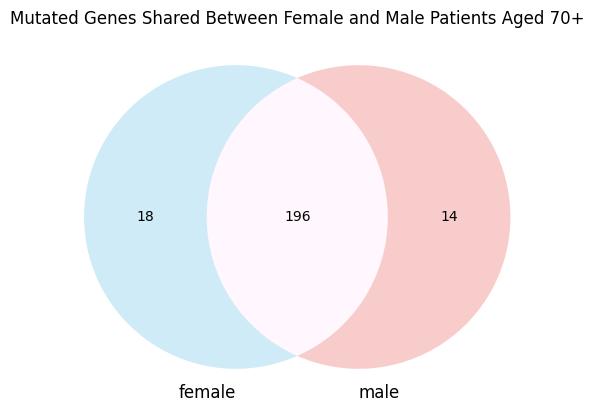

In [17]:
set1 = set(female_gene)
set2 = set(male_gene)

venn2_unweighted([set1, set2], ("female", "male"), set_colors=('skyblue', 'lightcoral'))
plt.title("Mutated Genes Shared Between Female and Male Patients Aged 70+")
plt.show()

common_genes = set1.intersection(set2)

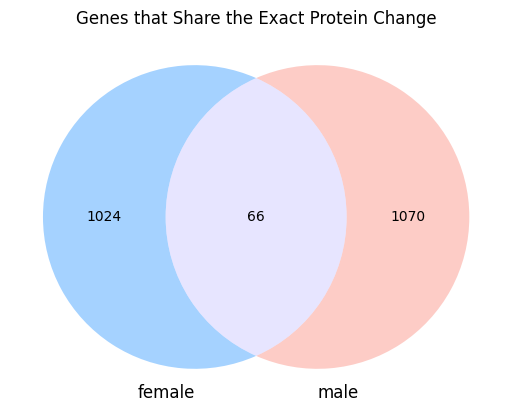

In [18]:
##### checking if the mutations are located in the same locations, causing the same changes in proteins

female_comb_set = set(female_filt["combined_key"])
male_comb_set = set(male_filt["combined_key"])


venn2_unweighted([female_comb_set, male_comb_set], ('female', 'male'), set_colors=('dodgerblue', 'salmon'))
plt.title("Genes that Share the Exact Protein Change")
plt.show()

###better to use intersection function than isin as it takes only the unique values and our data might not have unique mutations

intersection_mutloc = list(female_comb_set.intersection(male_comb_set))


In [19]:
### finding the unique genes to female and male patients

female_unique_gene = set1 - common_genes
female_unique_gene = list(female_unique_gene)

male_unique_gene = set2 - common_genes
male_unique_gene = list(male_unique_gene)

In [20]:
#### counting the amount of mutation per gene for different sexes

counts_male = male_filt.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].size().reset_index(name="Male Mutation Count")
counts_male_df = counts_male[counts_male['Hugo_Symbol'].isin(common_genes)]
print(counts_male_df)

counts_female = female_filt.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].size().reset_index(name="Female Mutation Count")
counts_female_df = counts_female[counts_female['Hugo_Symbol'].isin(common_genes)]
counts_female_df

    Hugo_Symbol  Male Mutation Count
0          ABL1                    3
1         ACVR1                    2
3          AKT3                    1
4           ALK                   10
5           APC                   30
..          ...                  ...
205         WRN                    5
206         WT1                    3
207        WWOX                    2
208         XPC                    3
209        XPO1                    4

[196 rows x 2 columns]


,Hugo_Symbol,Female Mutation Count
0,ABL1,2
1,ACVR1,1
3,AKT3,3
4,ALK,5
5,APC,32
...,...,...
209,WRN,1
210,WT1,4
211,WWOX,2
212,XPC,4


In [21]:
### setting the dataframes to have Hugo_Symbol column as the index

final_count_female= counts_female_df.set_index("Hugo_Symbol")
final_count_female

final_count_male= counts_male_df.set_index("Hugo_Symbol")
final_count_male

,Male Mutation Count
Hugo_Symbol,
ABL1,3
ACVR1,2
AKT3,1
ALK,10
APC,30
...,...
WRN,5
WT1,3
WWOX,2


In [22]:
### merging the dfs to use them in plots

merged_freq = pd.merge(final_count_female, final_count_male, how="inner", on="Hugo_Symbol")
mmerged_freq = merged_freq.reset_index()
print(merged_freq)
merged_freq_tr = merged_freq.transpose()
merged_freq_tr

             Female Mutation Count  Male Mutation Count
Hugo_Symbol                                            
ABL1                             2                    3
ACVR1                            1                    2
AKT3                             3                    1
ALK                              5                   10
APC                             32                   30
...                            ...                  ...
WRN                              1                    5
WT1                              4                    3
WWOX                             2                    2
XPC                              4                    3
XPO1                             6                    4

[196 rows x 2 columns]


Hugo_Symbol,ABL1,ACVR1,AKT3,ALK,APC,AR,ARAF,ARHGAP26,ATM,AURKA,...,TSC1,TSC2,U2AF1,VHL,WHSC1,WRN,WT1,WWOX,XPC,XPO1
Female Mutation Count,2,1,3,5,32,2,2,3,14,1,...,3,5,5,7,4,1,4,2,4,6
Male Mutation Count,3,2,1,10,30,1,2,4,22,1,...,7,5,3,8,2,5,3,2,3,4


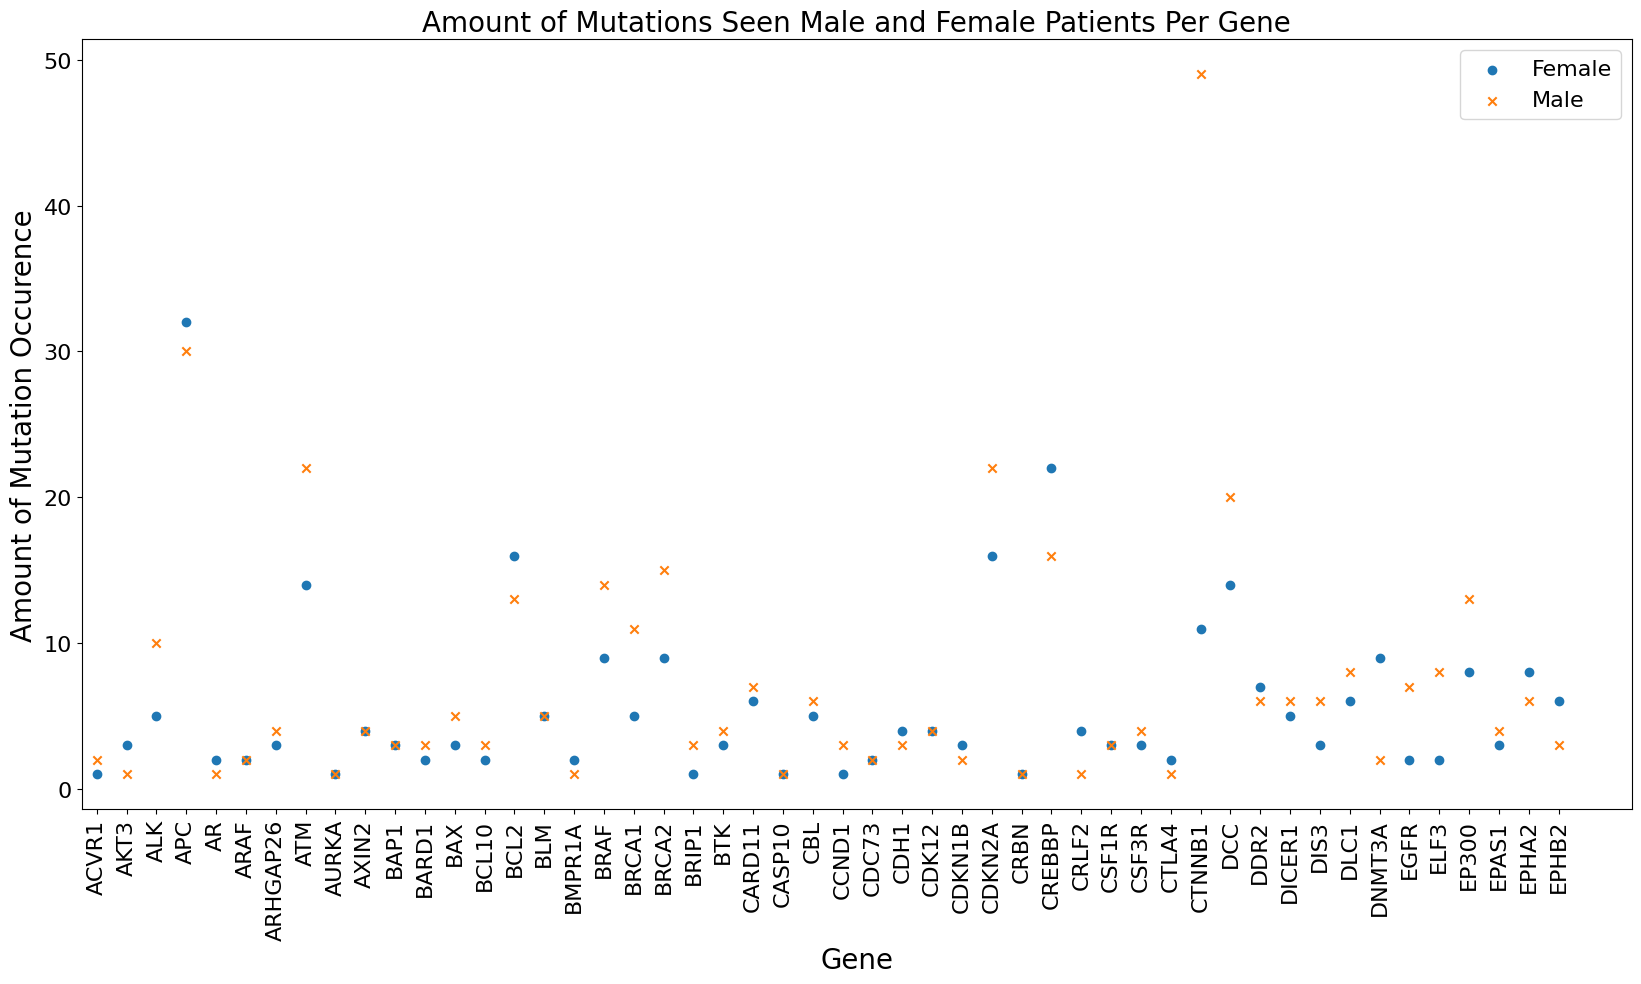

In [23]:
#### plot for the amount of mutations seen in the first 50 genes shared between males and females

plt.figure(figsize=(20,10))

plt.scatter(merged_freq_tr.columns[1:51], merged_freq_tr.iloc[0, 1:51], label='Female', marker='o')
plt.scatter(merged_freq_tr.columns[1:51], merged_freq_tr.iloc[1, 1:51], label='Male', marker='x')

plt.xlabel('Gene',fontsize=20)
plt.ylabel('Amount of Mutation Occurence',fontsize=20)
plt.title('Amount of Mutations Seen Male and Female Patients Per Gene',fontsize=20)
plt.legend(fontsize=16)


plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=-0.5)

plt.show()


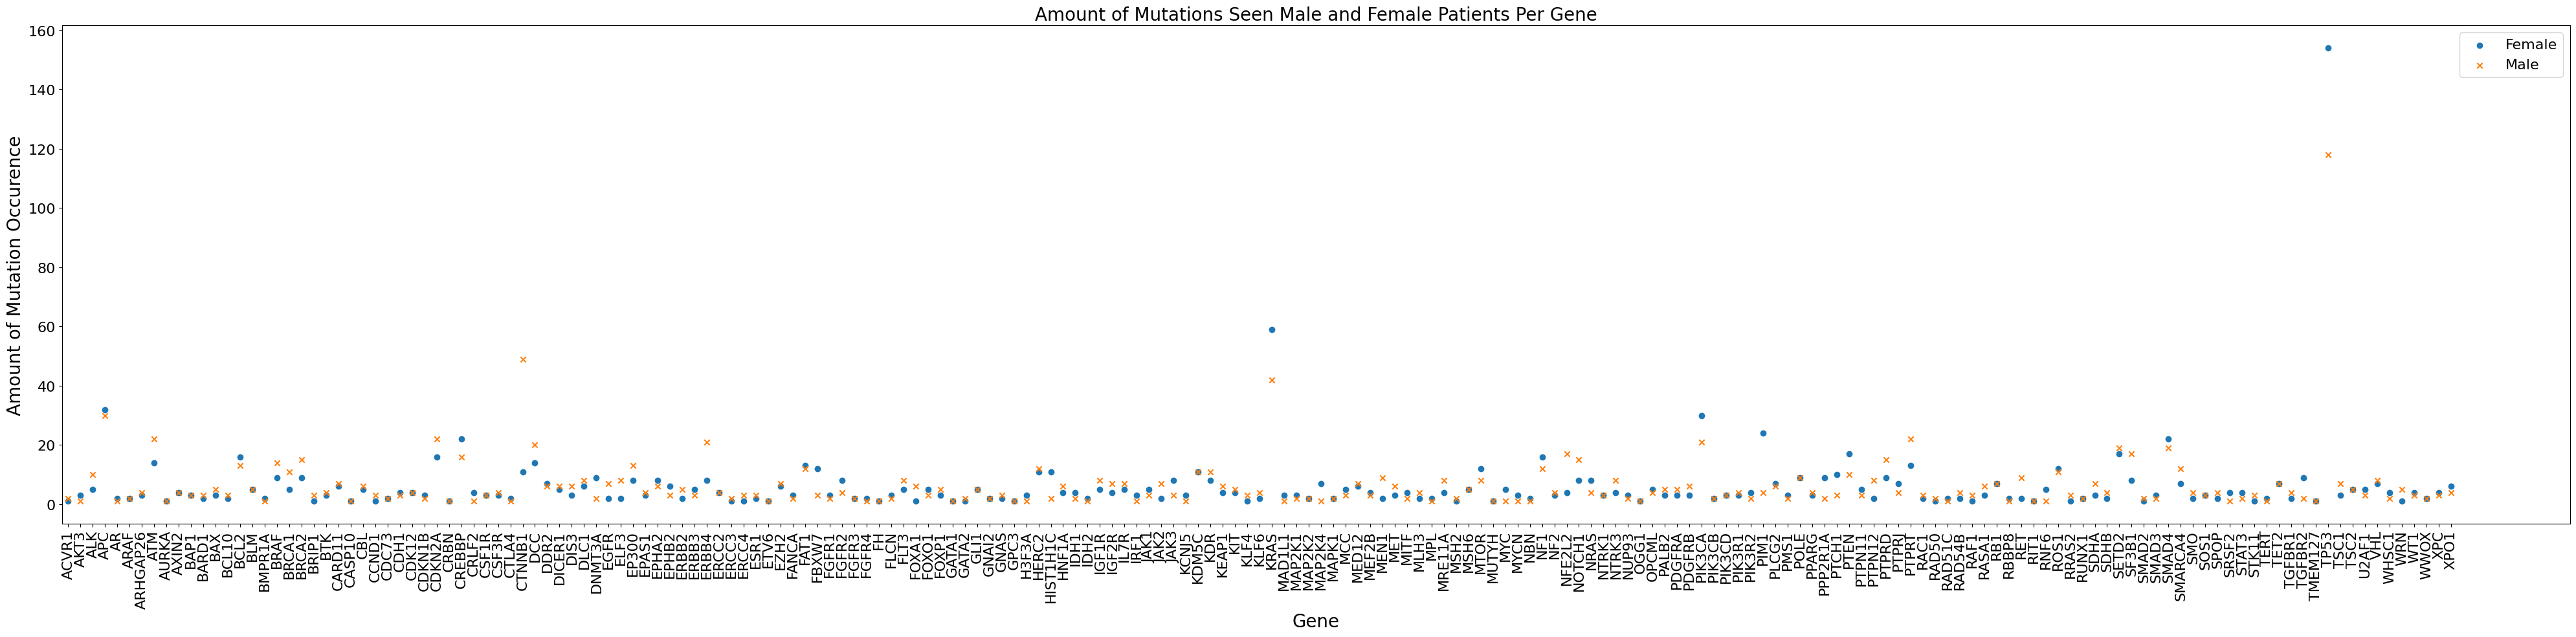

In [59]:
#### plot for the amount of mutations seen in all the genes shared between males and females

plt.figure(figsize=(50,10))

plt.scatter(merged_freq_tr.columns[1:], merged_freq_tr.iloc[0, 1:], label='Female', marker='o')
plt.scatter(merged_freq_tr.columns[1:], merged_freq_tr.iloc[1, 1:], label='Male', marker='x')

plt.xlabel('Gene',fontsize=20)
plt.ylabel('Amount of Mutation Occurence',fontsize=20)
plt.title('Amount of Mutations Seen Male and Female Patients Per Gene',fontsize=20)
plt.legend(fontsize=16)


plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=-0.5)

plt.show()

In [24]:
### merging the mutation data with sample-patient data to get a dataframe with all the information at hand

whole_df = pd.merge(mut_df_driver, sample_patient, how = "left", left_on = 'Tumor_Sample_Barcode', right_on ='SAMPLE_ID')
whole_df.columns

Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome',
       'Start_Position', 'End_Position', 'Strand', 'Consequence',
       'Variant_Classification', 'Variant_Type', 'Reference_Allele',
       'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'dbSNP_RS',
       'dbSNP_Val_Status', 'Tumor_Sample_Barcode',
       'Matched_Norm_Sample_Barcode', 'Match_Norm_Seq_Allele1',
       'Match_Norm_Seq_Allele2', 'Tumor_Validation_Allele1',
       'Tumor_Validation_Allele2', 'Match_Norm_Validation_Allele1',
       'Match_Norm_Validation_Allele2', 'Verification_Status',
       'Validation_Status', 'Mutation_Status', 'Sequencing_Phase',
       'Sequence_Source', 'Validation_Method', 'Score', 'BAM_File',
       'Sequencer', 't_ref_count', 't_alt_count', 'n_ref_count', 'n_alt_count',
       'HGVSc', 'HGVSp', 'HGVSp_Short', 'Transcript_ID', 'RefSeq',
       'Protein_position', 'Codons', 'Hotspot', 'Annotation_Status', 'DNA_VAF',
       'SAMPLE_ID', 'PATIENT_ID', 'PROJECT_CODE', 'STAGE'

In [26]:
whole_df

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,SEX,OS_STATUS,OS_MONTHS,FIRST_THERAPY,FIRST THERAPY_RESPONSE,AGE,TOBACCO_SMOKING_HISTORY_INDICATOR,TOBACCO_SMOKING_INTENSITY,ALCOHOL,ALCOHOL_HISTORY_INTENSITY
0,NTRK1,4914.0,NaN,GRCh37,1,156849089,156849089,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TP53,7157.0,NaN,GRCh37,17,7577058,7577058,+,stop_gained,Nonsense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDK12,51755.0,NaN,GRCh37,17,37680973,37680973,+,stop_gained,Nonsense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MYOD1,4654.0,NaN,GRCh37,11,17742999,17742999,+,missense_variant,Missense_Mutation,...,Male,0:LIVING,NaN,No Treatment,NaN,73.0,Lifelong non-smoker (<100 cigarettes smoked in...,NaN,No,NaN
4,PTPRT,11122.0,NaN,GRCh37,20,40827958,40827958,+,missense_variant,Missense_Mutation,...,Male,0:LIVING,NaN,No Treatment,NaN,73.0,Lifelong non-smoker (<100 cigarettes smoked in...,NaN,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8034,TET2,54790.0,NaN,GRCh37,4,106156345,106156345,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8035,TET2,54790.0,NaN,GRCh37,4,106157065,106157065,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8036,TET2,54790.0,NaN,GRCh37,4,106157884,106157884,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8037,TERT,7015.0,NaN,GRCh37,5,1264616,1264616,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
### final dataframe to be used in machine learning

final_na = whole_df[["Hugo_Symbol", "HGVSp", "SEX", "ORGAN_SYSTEM", "OS_STATUS"]]
final_df = final_na.dropna() ###data without NA values
final_df

,Hugo_Symbol,HGVSp,SEX,ORGAN_SYSTEM,OS_STATUS
3,MYOD1,p.Ala303Ser,Male,LIVER,0:LIVING
4,PTPRT,p.Asp824Asn,Male,LIVER,0:LIVING
5,NF2,p.Asn175Ser,Male,LIVER,0:LIVING
6,IL7R,p.Asp353Tyr,Male,LIVER,0:LIVING
11,FOXA1,p.Gly154Asp,Male,PROSTATE GLAND,0:LIVING
...,...,...,...,...,...
7982,MEN1,p.Trp270GlyfsTer16,Male,PANCREAS,0:LIVING
7983,DICER1,p.Asn126Asp,Male,"BLOOD, BONE MARROW, & HEMATOPOIETIC SYS",1:DECEASED
7984,TP53,p.Tyr220Cys,Male,"BLOOD, BONE MARROW, & HEMATOPOIETIC SYS",1:DECEASED
7985,PIK3R1,p.Ile535Phe,Male,"BLOOD, BONE MARROW, & HEMATOPOIETIC SYS",1:DECEASED


In [28]:
#### encoding of the data to contain binary values instead of categorical ones

final_dummies = pd.get_dummies(final_df, columns=["SEX", "Hugo_Symbol" , "HGVSp", "ORGAN_SYSTEM", "OS_STATUS"], dtype=float)
final_data = final_dummies.dropna()
final_data

,SEX_Female,SEX_Male,Hugo_Symbol_ABL1,Hugo_Symbol_ACVR1,Hugo_Symbol_AKT1,Hugo_Symbol_AKT2,Hugo_Symbol_AKT3,Hugo_Symbol_ALK,Hugo_Symbol_APC,Hugo_Symbol_AR,...,ORGAN_SYSTEM_PANCREAS,ORGAN_SYSTEM_PROSTATE GLAND,ORGAN_SYSTEM_RECTUM,ORGAN_SYSTEM_SKIN,ORGAN_SYSTEM_STOMACH,ORGAN_SYSTEM_THYROID GLAND,ORGAN_SYSTEM_URINARY BLADDER,"ORGAN_SYSTEM_UTERUS, NOS",OS_STATUS_0:LIVING,OS_STATUS_1:DECEASED
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7982,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7983,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7984,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7985,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
### dropping the male column so that data can only predict if a patient is a female or not
### when a patient is not a female, it is a male

no_male = final_data.drop(columns=["SEX_Male"])

,SEX_Female,Hugo_Symbol_ABL1,Hugo_Symbol_ACVR1,Hugo_Symbol_AKT1,Hugo_Symbol_AKT2,Hugo_Symbol_AKT3,Hugo_Symbol_ALK,Hugo_Symbol_APC,Hugo_Symbol_AR,Hugo_Symbol_ARAF,...,ORGAN_SYSTEM_PANCREAS,ORGAN_SYSTEM_PROSTATE GLAND,ORGAN_SYSTEM_RECTUM,ORGAN_SYSTEM_SKIN,ORGAN_SYSTEM_STOMACH,ORGAN_SYSTEM_THYROID GLAND,ORGAN_SYSTEM_URINARY BLADDER,"ORGAN_SYSTEM_UTERUS, NOS",OS_STATUS_0:LIVING,OS_STATUS_1:DECEASED
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
### identifying the predictor features (X) and target (y)

X = no_male.drop(columns=["SEX_Female"]).to_numpy()
y = no_male["SEX_Female"]
no_male

,SEX_Female,Hugo_Symbol_ABL1,Hugo_Symbol_ACVR1,Hugo_Symbol_AKT1,Hugo_Symbol_AKT2,Hugo_Symbol_AKT3,Hugo_Symbol_ALK,Hugo_Symbol_APC,Hugo_Symbol_AR,Hugo_Symbol_ARAF,...,ORGAN_SYSTEM_PANCREAS,ORGAN_SYSTEM_PROSTATE GLAND,ORGAN_SYSTEM_RECTUM,ORGAN_SYSTEM_SKIN,ORGAN_SYSTEM_STOMACH,ORGAN_SYSTEM_THYROID GLAND,ORGAN_SYSTEM_URINARY BLADDER,"ORGAN_SYSTEM_UTERUS, NOS",OS_STATUS_0:LIVING,OS_STATUS_1:DECEASED
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
### RandomForestClassifier with default parameters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for RandomForestClassifier: {}".format(accuracy))

[[200  66]
 [ 81 144]]
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73       266
         1.0       0.69      0.64      0.66       225

    accuracy                           0.70       491
   macro avg       0.70      0.70      0.70       491
weighted avg       0.70      0.70      0.70       491

Accuracy for RandomForestClassifier: 0.7006109979633401


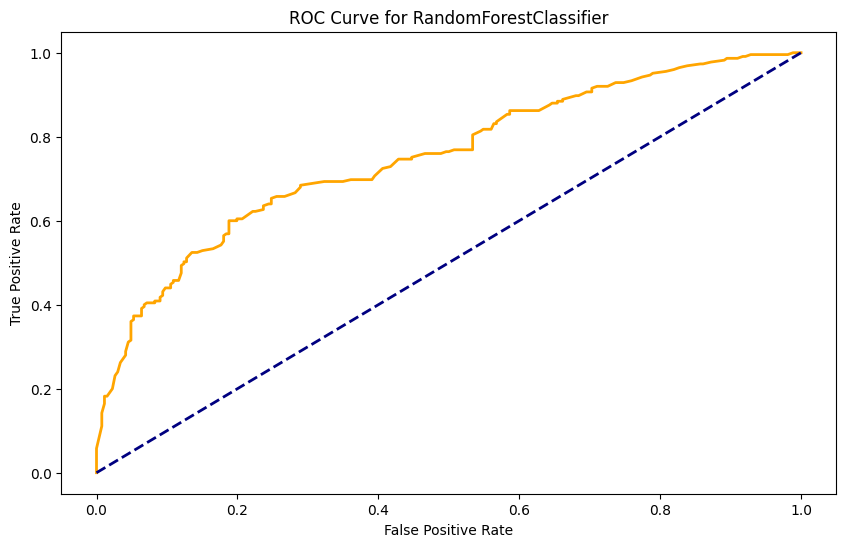

In [51]:
### plotting a ROC curve

y_scores = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForestClassifier')
plt.show()

In [52]:
### ROC AUC score

y_pred_prob = classifier.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred_prob)

0.7509273182957394

In [33]:
clf = RandomForestClassifier(n_estimators = 100)
print("Cross Validation Score for RandomForestClassifier: {}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=10))))

Cross Validation Score for RandomForestClassifier: 0.6605485341344659


In [35]:
### RandomForestClassifier with hyperparameter-tuning with GridSearchCV


param_grid = { 
    "n_estimators": [25, 50, 100, 150], 
    "max_features": ["sqrt", "log2", None], 
    "max_depth": [None, 3, 6, 10, 20], 
    "criterion": ["gini", "entropy"],
    "max_leaf_nodes": [None, 1, 3, 6, 9], 
} 

In [36]:
### GridSearch for RandomForestClassifier

grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(X_train, y_train) 
print(grid_search.best_estimator_) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
600 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.

RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None,
                       n_estimators=50)


In [37]:
### RandomForestClassifier with updated parameters after gridsearch

model_grid = RandomForestClassifier(criterion='entropy', 
                                    max_depth=20, 
                                    max_features=None, 
                                    n_estimators=50) 
model_grid.fit(X_train, y_train) 
y_pred_grid = model_grid.predict(X_test) 

print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid)) 

accuracy = accuracy_score(y_test, y_pred_grid)
print("Accuracy for RandomForestClassifier with GridSearchCV: {}".format(accuracy))


[[214  52]
 [ 88 137]]
              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75       266
         1.0       0.72      0.61      0.66       225

    accuracy                           0.71       491
   macro avg       0.72      0.71      0.71       491
weighted avg       0.72      0.71      0.71       491

Accuracy for RandomForestClassifier with GridSearchCV: 0.714867617107943


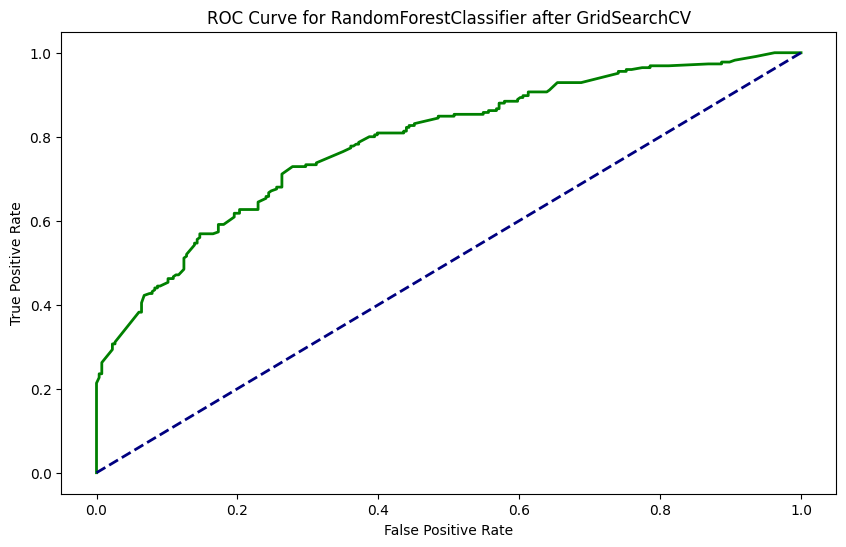

In [53]:
### ROC curve for RandomForestClassifier with updated parameters after gridsearch

y_scores = model_grid.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='green', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForestClassifier after GridSearchCV')
plt.show()

In [54]:
### ROC AUC score

y_pred_prob = model_grid.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred_prob)

0.7875522138680033

In [39]:
print("Cross Validation Score for RandomForestClassifier with GridSearchCV: {}".format(np.mean(cross_val_score(model_grid, X_train, y_train, cv=10))))

Cross Validation Score for RandomForestClassifier with GridSearchCV: 0.6967264062985601


Support Vector Machines (without hyperparameter tuning without GridSearchCV)

In [40]:
#### SVC with default parameters

svm_classifier = SVC(kernel= "linear", random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)


print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy for SVC: {}".format(accuracy))

[[189  77]
 [ 97 128]]
              precision    recall  f1-score   support

         0.0       0.66      0.71      0.68       266
         1.0       0.62      0.57      0.60       225

    accuracy                           0.65       491
   macro avg       0.64      0.64      0.64       491
weighted avg       0.64      0.65      0.64       491

Accuracy for SVC: 0.6456211812627292


In [41]:
svc = SVC()
print("Cross Validation Score for SVC: {}".format(np.mean(cross_val_score(svc, X_train, y_train, cv=10))))

Cross Validation Score for SVC: 0.7007976794778824


Support Vector Machines (without hyperparameter tuning with GridSearchCV)

In [43]:
#### SVC hyperparameter tuning with GridSearchCV

param_grid = {"C": [0.1, 1, 10, 100, 1000],   
              "kernel": ['rbf'],
              "degree": [2, 3, 4],
              "gamma": ['scale', 'auto', 0.1, 1, 10]
}  
  
search_grid = GridSearchCV(SVC(), param_grid) 
  
# fitting the model for grid search 
search_grid.fit(X_train, y_train) 


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.1, 1, 10],
                         'kernel': ['rbf']})

In [44]:
print(search_grid.best_estimator_)

SVC(C=1, degree=2, gamma=0.1)


In [45]:
#### SVC with parameters updated after gridsearch

SVC_grid = SVC(C= 1,
              kernel= "rbf",
              degree= 2,
              gamma=0.1)
SVC_grid.fit(X_train, y_train) 
y_pred_grid = SVC_grid.predict(X_test) 

print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid)) 

accuracy = accuracy_score(y_test, y_pred_grid)
print("Accuracy for SVC with GridSearchCV: {}".format(accuracy))  

[[210  56]
 [ 80 145]]
              precision    recall  f1-score   support

         0.0       0.72      0.79      0.76       266
         1.0       0.72      0.64      0.68       225

    accuracy                           0.72       491
   macro avg       0.72      0.72      0.72       491
weighted avg       0.72      0.72      0.72       491

Accuracy for SVC with GridSearchCV: 0.7230142566191446


In [46]:
from sklearn.model_selection import cross_val_score
print("Cross Validation Score for SVC with GridSearchCV: {}".format(np.mean(cross_val_score(SVC_grid, X_train, y_train, cv=10))))

Cross Validation Score for SVC with GridSearchCV: 0.7018232673780173
